# Spring 2019 CX4240 Homework 4

## Dr. Mahdi Roozbahani

## Deadline: April 17, Wednesday, 11:59 pm

* No unapproved extension of the deadline is allowed. Late submission will lead to 0 credit. 

* Discussion is encouraged, but each student must write his own answers and explicitly mention any collaborators.

# Part 1 Descriptive Questions (45pts)


You could type with Latex (directly type in the markdown). Hand-writting is also acceptable. If you hand write, you could scan your answer and include it as a picture. If you want to add any picture to your answer, use this syntax $"<img src="" style="width: 500px;"/>"$ to include them within your ipython notebook.

## 1 SVM Concepts (20pts)

(1) What linear function is used by a SVM for classification? How is an input vector $x_i$ (instance) assigned to the positive or negative class? (5pts)

(A) The linear function used is $w^T x + b$. An input vector is assigned to the positive class if $f(x_i) < 0$ and to the negative class if $f(x_i) >= 0$ 

(2) If the training examples are linearly separable, how many decision boundaries can separate positive from negative data points? Which decision boundary does the SVM algorithm calculate? Why? (5pts)

(A) If training is linearly separable, there are infinite number of decision boundaries that can separate negative from positive data points. The SVM calculates the decision boundary with the largest margin to increase confidence in correct assginment of data points.

(3) What is the margin? Which are the equations of the two margin hyperplans $H_+$ and $H_-$ ? (5pts)

(A) Margin is te distance from decision boundary to closest data point and that same distance to the other side of the boundary. <br>
$H_+ = w^T x + b = 1$  <br>
$H_- = w^T x + b = -1$

(4) Summarize the main advantages and limitations of SVM. (5pts)

Advatage: The regularization parameters lets users avoid overfitting, the kernel can be adjusted to user preference, is efficient to solve depending on methods, and work well with unstructured data 

Limitations: Deciding on a kernel function is hard and can be sensitive, training time can be long, need a model per class in multiclass problems

## 2 SVM Kernel (25pts)

Suppose we have a dataset in 1-dimensional space which consists of 3 data points ${−1, 0, 1}$ with the positive label and 3 data points ${−3, −2, 2}$ with the negative label.

(1) Find a feature map $(R1 → R2)$, which will map the original 1-dimensional data points to the 2-dimensional feature space so that the positive samples and the negative samples are linearly separable with each other. Draw the dataset after mapping in the 2-dimensional space. (10pts)

same plot below

(2) In your plot above, draw the decision boundary given by hard-margin linear SVM. Mark the corresponding support vectors. (5pts)

<img src="Capture.PNG" style="width: 500px;"/>

(3) For the feature map you use, what is the corresponding kernel $K(x_1,x_2)$? (10pts)

The kernel used is 
$K(x_1,x_2) = \phi(x_1)^T \phi(x_2) = [x_1,x_1^2]^T [x_2,x_2^2] = x_1 x_2 + x_1^2 x_2^2$

# Part 2 Coding Questions (55pts + extra 10 bonus points)


We are going to implement a neural network that can be used to classify the images. 

Make sure the packages imported below are installed. These packages should be enough for you to finish this homework.

**You don't need to modify the block below.**

In [35]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gzip
import pickle
from tqdm import tqdm_notebook as tqdm
from abc import ABC, abstractmethod

Below are some abstract classes defined for neural network layers. 

The neural networks we are talking about here consist of several stacked 'layers'. Each layer is an operation that processes the output from previous layer, and feed the output to next layer.

Here are several common functions. It is ok if it doesn't look familiar for now, we will get into them step by step. 

(1) forward: corresponds to the 'forward pass' in the class notes.

(2) backward_input: taking derivatives with respect to some inputs.

(3) backward_param: taking derivatives with respect to the parameters $\theta$

**You don't need to modify the block below.**

In [36]:
DTYPE = np.float32

class Layer(ABC):
    def __init__(self):
        pass
    @abstractmethod
    def forward(self, h_in):
        raise NotImplementedError
    @abstractmethod
    def backward_input(self, h_in, h_out, d_hout):
        raise NotImplementedError

class ParamLayer(Layer):
    def __init__(self):
        self.params = dict()

    @abstractmethod
    def backward_param(self, h_in, h_out, d_hout):
        raise NotImplementedError    


And here are some utility functions. 

How to initialize the weights in the neural network is an interesting research topic, since different initializations will probably lead to very different final results. Here we just use one type of initialization which is commonly used in the literature.

If you are interested in more details, it is called glorot_uniform, which is used to initialize the weights of the fully connected layers. See [this paper](http://proceedings.mlr.press/v9/glorot10a.html).

**You don't need to modify the block below.**

In [37]:
def weight_init(out_size, in_size):
    limit = np.sqrt(6.0 / (in_size + out_size))
    return np.random.uniform(-limit, limit, size=[out_size, in_size]).astype(DTYPE)

## Overview of the architecture

Let's start from the picture we have seen in the class. It is a neural network that contains one input layer, one hidden layer, and one output layer.

The weights between input and first hidden layer is called the first fully connected layer (FCLayer), since it connects all neurons between these two layers. So as for the second FCLayer.

After the FCLayer, the sigmoid function we see in the class is called activation functin, where we call it SigmoidLayer in this homework for consistency. 

![title](nn.png)


Below we first introduce the task, and then start with the implementation of the objective function, and next implement the forward and backward pass for the FCLayer and SigmoidLayer. 



Our task is to classify the hand written digits from zero to nine (totally 10 digits).

Let's load the MNIST dataset, and display some of the training images to get a better idea of what we are going to do. For more information about MNIST and its history, you can read [this](http://yann.lecun.com/exdb/mnist/) if you are interested.

**You don't need to modify the block below.**

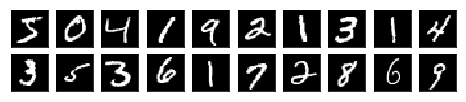

In [38]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='bytes')

train_imgs, train_labels = train_set
fig = plt.figure(figsize=(8, 8))
# plot several images
for i in range(20):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    img = np.reshape(train_imgs[i], (28, 28))
    ax.imshow(img, cmap='gray')

Each image is of size 28x28=784. We flat the image and use this 784-dimension vector as the feature representation for each image. In total we have 50k images for training, 10k images for validation and another 10k images for test.

**You don't need to modify the block below.**

In [39]:
print('train images', train_set[0].shape)
print('validation images', valid_set[0].shape)
print('test images', test_set[0].shape)

train images (50000, 784)
validation images (10000, 784)
test images (10000, 784)


### 1. Mean Square Error layer (14pts)

Our objective is to minimize the MSE, i.e.,:

$$E(\theta) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \|\vec{y_i} - \hat{y}(x_i; \theta)\|^2$$

Where $y_i$ is the true label, and $\hat{y}$ is our prediction. 

In class we have learned the case where $y \in \mathbb{R}$ is a scalar. In this homework, we make a bit of extension to that, in which $y \in \mathbb{R}^{10}$ is a 10-dimensional vector. The reason is, we want to use this neural network to classify the 10 types of digits.

We use one-hot representation for the true label. For example, if the label of $i$-th instance is class 4, then the one-hot representation would be $y_i = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$. 

**Note that MSE is not a standard loss function for multi-class classification. We use this in the homework simply because it is simpler to calculate the gradient.**

Below we have a helper function that converts the class label into 10-dimensional one-hot vector.

**You don't need to modify the block below.**

In [40]:
def get_onehot(labels):
    one_hot = np.zeros((len(labels), 10), dtype=DTYPE)
    one_hot[range(len(labels)), labels] = 1.0
    return one_hot

#### Implementation: Mean Square Error calculation and derivatives.

Now it's time to get your hands dirty. You are asked to implement the two functions below.

(1) forward (**7pts**): given the true labels and prediction $\hat{y_i}$, first convert the labels into one-hot representation $y_i$, then calculate the error $\frac{1}{2}\|y_i - \hat{y_i}\|^2$. Note that there will be N instances fed into this function, so you need to return the average MSE. 

(2) backward_input (**7pts**): you are asked to implement the derivatives with respect to your prediction, 
$$\frac{\partial E_i}{\partial \hat{y}_i} = y_i - \hat{y}_i$$. Do this for all the N instances in this batch, and return a matrix with size $N * 10$.

In [57]:
class MeanSquareError(Layer):
    
    def forward(self, labels, predict):
        one_hot_label = get_onehot(labels)
        N = predict.shape[0]
        loss = []
        for i in range(N):
            err = 0.5 * np.linalg.norm(predict[i,:] - one_hot_label[i,:])**2 
            loss = np.append(loss, err)
        loss = np.mean(loss)
        return loss

    def backward_input(self, labels, predict):
        one_hot_label = get_onehot(labels)
        deriv = predict - one_hot_label
        return deriv

### 2. Fully connected layer (21pts)

Below you are asked to implement the forward, backward_input and backward_param functions. 

Note that the multiplication '$*$' below means matrix multiplication (i.e., np.dot)

(1) forward (**7pts**): let's copy the architecture figure below:

<img src="fc.png" style="width: 150px;"/>


In the above example, we have $x$ of dimension 1, and hidden layer of dimension 2, then we'll have 1 * 2 + 2 parameters for $\theta$ in this layer. 

Let's redefine the notation a bit: $\theta_{1, 0} = \theta_{1}$, $\theta_{2, 0} = \theta_{2}$, $\theta_{1, 1} = \theta_{3}$, $\theta_{2, 1} = \theta_{4}$

If we have $x$ of dimension 784, and hidden layer of size 1024, then we'll have 784 * 1024 + 1024 parameters for $\theta$ in this layer. The $i$-th neuron $u_{i} = \sum_{j=1}^{784} x_j * \theta_{i, j} + \theta_{i, 0}$.  

To make the notation simple, let $W \in \mathbb{R}^{1024 * 784}$ be the weight matrix, where $W_{i, j} = \theta_{i, j}$. And let $b \in \mathbb{R}^{1024}$ be the bias vector, where $b_i = \theta_{i, 0}$. Then we can rewrite the above summation in the matrix format:

$$\vec{u} = \vec{x} * W^\top + b$$

**Keep the above equation in mind, as it is need for both forward and backward implementations.**

You are supposed to write the above matrix multiplication inside the forward function.

(2) backward_input (**7pts**): we want the derivatives w.r.t input $\vec{x}$, i.e., $\frac{\partial E(\theta)}{\partial \vec{x}}$. 

use the chain rule, $\frac{\partial E(\theta)}{\partial \vec{x}} = \frac{\partial E(\theta)}{\partial \vec{u}} * \frac{\partial \vec{u}}{\partial \vec{x}}$. 

$\frac{\partial E(\theta)}{\partial \vec{u}}$ will be provided as an argument to this function, so you are only asked to implement $\frac{\partial \vec{u}}{\partial \vec{x}} and get the chain rule done.

(3) backward_param (**7pts**):  we want the derivatives w.r.t parameter $W, b$, i.e., $\frac{\partial E(\theta)}{\partial W}$ and $\frac{\partial E(\theta)}{\partial b}$. 

use the chain rule again, $\frac{\partial E(\theta)}{\partial W} = \frac{\partial E(\theta)}{\partial \vec{u}} * \frac{\partial \vec{u}}{\partial W}$. 

and 

$\frac{\partial E(\theta)}{\partial b} = \frac{\partial E(\theta)}{\partial \vec{u}} * \frac{\partial \vec{u}}{\partial b}$.

Again, the $\frac{\partial E(\theta)}{\partial \vec{u}}$ will be provided to this function, so you are only asked to implement $\frac{\partial \vec{u}}{\partial W}$ and $\frac{\partial \vec{u}}{\partial b}$, to get the chain rule done.

**You don't need to modify __init__**

#### Implementation: You are asked to implement forward, backward_input, backward_param. 

In [58]:
class FCLayer(ParamLayer):
    def __init__(self, out_size, in_size):
        """
        Args:
            out_size: output dimension
            in_size: input dimension
        """ 
        super(FCLayer, self).__init__()
        self.out_size = out_size
        self.in_size = in_size
        self.params["weight"] = weight_init(out_size, in_size)
        self.params["bias"] = np.zeros(out_size, dtype=DTYPE)

    def forward(self, x):
        """
        Args:
            x: array of size N x in_size, where N is the batch size
        Return:
            u: array of size N x out_size
        """
        Wt = np.transpose(self.params["weight"])
        u = np.dot(x, Wt) + self.params["bias"]
        return u 

    def backward_input(self, x, u, de_du):
        """
        Args:
            x: array of size N x in_size, where N is the batch size
            u: array of size N x out_size, 
            de_du: \frac{\partial E(\theta)}{\partial \vec{u}} in the above equation
        Return:
            de_dx: \frac{\partial E(\theta)}{\partial \vec{x}} in the above equation
        """
        de_dx = np.dot(de_du, self.params["weight"])
        return de_dx

    def backward_param(self, x, u, de_du):
        """
        Args:
            x: array of size N x in_size, where N is the batch size
            u: array of size N x out_size, 
            de_du: \frac{\partial E(\theta)}{\partial \vec{u}} in the above equation
        Return:
            dictionary of {
                "weight": \frac{\partial E(\theta)}{\partial W} in the above equation
                "bias": \frac{\partial E(\theta)}{\partial b} in the above equation
            }
        """
        N = x.shape[0]
        de_dw = np.dot(de_du.T, x)
        de_db = np.dot(de_du.T, np.ones(N))
        D = {} 
        D["weight"] = de_dw 
        D["bias"] = de_db 
        return D 

### 3. Sigmoid activation layer implementation (14pts)

One key component in a neural network is the nonlinear activation function. 

<img src="sigmoid.png" style="width: 150px;"/>


**forward implementation (7pts)**

$O = Sigmoid(\mu) = \frac{1}{1 + \exp(-\mu)}$

**backward_input implementation (7pts)**
Use the notes in the class to get the derivatives. 

$\frac{\partial E(\theta)}{\partial \mu} = \frac{\partial E(\theta)}{O} * \frac{\partial O}{\partial \mu}$.

$\frac{\partial E(\theta)}{O}$ will be provided as the input to the function. You are only asked to calculate 
$\frac{\partial O}{\partial \mu}$ and get the chain rule done. 

In [59]:
class SigmoidLayer(Layer):

    def forward(self, u):
        """
        Args:
            u: array of size N x D, where N is the batch size
        Return:
            O: array of size N x D
        """
        return 1/(1+np.exp(-u))
    
    def backward_input(self, u, O, de_dO):
        """
        Args:
            u: array of size N x D, where N is the batch size
            O: array of size N x D, 
            de_dO: \frac{\partial L}{\partial h}
        Return:
            de_du: \frac{\partial L}{\partial x}
        """
        dO_du = np.dot(O.T, 1-O)
        de_du = np.dot(de_dO, dO_du)
        return de_du

### Optional: ReLU (Rectifier linear unit) activation layer implementation

**You will get extra 10pts bonus points if you also implement this one correctly.**

Another option is Relu. In this setting, the Relu will have ~20% accuracy boost from sigmoid function, after 10 epochs of training. 

For each neuron $x$ in the corresponding hidden layer $h_i$, the relu function is:

$Relu(x) = x$, if $x > 0$, else $0$

The derivative can be calculated for all $x$ except at $x=0$, where the function is not smooth. One practice is to simply ignore the case when x=0.

In [60]:
class ReLULayer(Layer):

    def forward(self, h_in):
        """
        Args:
            h_in: array of size N x D, where N is the batch size
        Return:
            h_out: array of size N x D
        """        
        return np.maximum(0,h_in)

    def backward_input(self, h_in, h_out, d_hout):
        """
        Args:
            h_in: array of size N x in_size, where N is the batch size
            h_out: array of size N x out_size, 
            d_hout: \frac{\partial L}{\partial h} in the above equation
        Return:
            d_hin: \frac{\partial L}{\partial x} in the above equation
        """
        return 1. * (h_in > 0)

No matter which one you implemented, choose the one that is to be used later:

In [61]:
# uncomment below if you use sigmoid
ACT_FUNC = SigmoidLayer
# uncomment below if you use relu
#ACT_FUNC = ReLULayer

### 4. Neural Network implementation (6pts)


Now we are ready to put everything together and get our neural network assembled!

We call it MLP (multi layer perception). 

**To make it simple, you are only required to implement the "update" function, which corresponds to the SGD update operation.**

$$W = W - \eta * dW$$, where $W$ is the parameter you want to update, $\eta$ is the learning rate.


In [62]:
class MLP(object):
    def __init__(self, in_dim, hidden_dims, out_dim):
        """Do not modify"""
        self.act_layer = ACT_FUNC()
        
        dims = [in_dim] + hidden_dims + [out_dim]
        self.fc_layers = []
        for i in range(len(dims) - 1):
            fc_layer = FCLayer(out_size=dims[i + 1], in_size=dims[i])
            self.fc_layers.append(fc_layer)
        self.loss_func = MeanSquareError()
        
    def forward(self, img_input, img_label):
        """Do not modify"""
        x = img_input
        self.hiddens = [x]
        for i in range(len(self.fc_layers)):
            x = self.fc_layers[i].forward(x)
            self.hiddens.append(x)
            if i + 1 < len(self.fc_layers):
                x = self.act_layer.forward(x)
                self.hiddens.append(x)
        logits = x
        loss = self.loss_func.forward(img_label, logits)
        predict = np.argmax(logits, axis=1)
        accuracy = np.mean(predict == img_label)
        return loss, accuracy

    def backward(self, img_label):
        """Do not modify"""
        grad = self.loss_func.backward_input(img_label, self.hiddens[-1])
        idx = len(self.hiddens) - 1
        self.layer_grads = [None] * len(self.fc_layers)
        for i in range(len(self.fc_layers) - 1, -1, -1):
            assert idx >= 1
            g_param = self.fc_layers[i].backward_param(self.hiddens[idx - 1], self.hiddens[idx], grad)
            self.layer_grads[i] = g_param
            grad = self.fc_layers[i].backward_input(self.hiddens[idx - 1], self.hiddens[idx], grad)            
            idx -= 1
            if i > 0:
                grad = self.act_layer.backward_input(self.hiddens[idx - 1], self.hiddens[idx], grad)
                idx -= 1
        assert idx == 0

    def update(self, learning_rate):
        """
        Args:
            learning_rate: scalar, the \eta in above
        """
        for i in range(len(self.fc_layers)):
            grad_params = self.layer_grads[i]
            params = self.fc_layers[i].params
            # params is a dictionary of parameters: {'weight': np array, 'bias': np array}
            # grad_params is a dictionary of gradients w.r.t. parameters: {'weight': np array, 'bias': np array}            
            # TODO: update params["weight"] and params["bias"] with grad_params["weight"] and grad_params["bias"]
            
            params["weight"] = params["weight"] - learning_rate *  grad_params["weight"]
            #params["weight"] -= np.dot(learning_rate, grad_params["weight"])
            params["bias"] = params["bias"] - learning_rate * grad_params["bias"]
            #params["bias"] -= np.dot(learning_rate, grad_params["bias"])
    

To handle the MNIST, we create a neural network with 2 hidden layers, each of them has size of 1024.
Since it is a 10-class classification problem, the neural network will have an output of size 10.

To summarize, the neural network has the layer sizes of 784 -> 1024 -> 1024 -> 10

**You don't need to modify the block below.**

In [63]:
np.random.seed(1)
net = MLP(784, [1024, 1024], 10)

Let's train it for 10 epochs (i.e., go through the training dataset for 10 times), report the validation performance after each epoch. 

**You don't need to modify the block below.**

In [64]:
def loop_over_dataset(net, imgs, labels, is_training, batch_size=100):
    loss_list = []
    acc_list = []
    pbar = range(0, imgs.shape[0], batch_size)
    if is_training:
        pbar = tqdm(pbar)
    for i in pbar:
        x = imgs[i : i + batch_size, :]
        y = labels[i : i + batch_size]
        loss, acc = net.forward(x, y)
        if is_training:
            net.backward(y)
            net.update(5e-5)
        loss_list.append(loss)
        acc_list.append(acc)
        if is_training:
            pbar.set_description('loss: %.4f, acc: %.4f' % (loss, acc))
    if not is_training:
        print('average loss:', np.mean(loss_list))
        print('average accuracy:', np.mean(acc_list))

num_epochs = 2
for e in range(num_epochs):
    print('training epoch', e + 1)
    loop_over_dataset(net, train_set[0], train_set[1], is_training=True)
    print('validation')
    loop_over_dataset(net, valid_set[0], valid_set[1], is_training=False)

training epoch 1


validation
average loss: 0.45025395555079734
average accuracy: 0.1064
training epoch 2


validation
average loss: 0.44993655767660734
average accuracy: 0.1064


And do the evaluation on the test set. 

**You don't need to modify the block below.**

In [ ]:
loop_over_dataset(net, test_set[0], test_set[1], is_training=False)